In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import glob
import re 
import numpy as np
import os 
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = cm.viridis

m = cm.ScalarMappable(norm=norm, cmap=cmap)
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
!ls ./graphs/

charge-relax-v0-_ediff.csv
charge-relax-v0-_ediff3.png
charge-relax-v0-_ediff4.png
charge-relax-v0-_ediff5.png
charge-relax-v0-inplane_ion_energies.csv
charge-relax-v0-perp_ion_energies.csv
charge-relax-v01-_ediff.csv
charge-relax-v01-_ediff3.png
charge-relax-v01-_ediff4.png
charge-relax-v01-_ediff5.png
charge-relax-v01-inplane_ion_energies.csv
charge-relax-v01-perp_ion_energies.csv
charge-relax-v02-_ediff.csv
charge-relax-v02-_ediff3.png
charge-relax-v02-_ediff4.png
charge-relax-v02-_ediff5.png
charge-relax-v02-inplane-popr_ion_energies.csv
charge-relax-v02-perp_ion_energies.csv


In [3]:
def plot_pma_concentration(filename, max_concentration=5, monolayers=[4]):
    df = pd.read_csv(filename)
    if monolayers:
        df = df[df['ion_position'].isin(monolayers)]
    df['Fe_concentration'] = df['filename'].apply(lambda x: int(
        re.match(r'(Fe)([0-9])(Co)', x).group(2)) / max_concentration) * 100
    df['PMA'] = df['DE'] * 1000
    fig, ax = plt.subplots()

    for concentration, pma, ion_pos in zip(df['Fe_concentration'], df['PMA'], df['ion_position']):
        txt = f"{ion_pos}: {np.around(pma, decimals=2)}"
        ax.annotate(txt, (concentration, pma))
        colour = m.to_rgba(concentration)
        plt.plot(concentration, pma, '.', color=colour, markersize=8)
    plt.xlabel('Fe concentration [%]')
    plt.ylabel('PMA energy [mJ]')
    if monolayers:
        monolayers = [str(l) for l in monolayers]
        plt.title("PMA energy in function of Fe concentration ML: " + ','.join(monolayers))
    else:
        plt.title("PMA energy in function of Fe concentration")

    plt.grid()
    plt.show()
    if monolayers:
        savename = filename.replace('.csv', '_'.join(monolayers)+'.png')
    else:
        savename = filename.replace('.csv', '.png')
    fig.savefig(f'{savename}')

# plot_pma_concentration(diff_df)

In [8]:
# df_v0_inplane = pd.read_csv('./graphs/charge-relax-v0-inplane_ion_energies.csv')
# df_v0_perpend = pd.read_csv('./graphs/charge-relax-v0-perp_ion_energies.csv')

common_dir = './graphs'
def calculate_and_plot_all_folders():
    for inplane, perp in [
        ('charge-relax-v0-inplane_ion_energies.csv',
         'charge-relax-v0-perp_ion_energies.csv'),
        ('charge-relax-v01-inplane_ion_energies.csv',
         'charge-relax-v01-perp_ion_energies.csv'),
        ('charge-relax-v02-inplane-popr_ion_energies.csv',
         'charge-relax-v02-perp_ion_energies.csv')
    ]:
        fn, df = monolayer_energy_difference(os.path.join(common_dir,inplane),
                                         os.path.join(common_dir, perp))
        # sum of all monolayers 
        print(df)
#         for monolayer in [3, 4, 5]:
#             plot_pma_concentration(fn, monolayers=[monolayer])
    
def monolayer_energy_difference(inplane_csv, perp_csv):
    df_v0_inplane = pd.read_csv(inplane_csv)
    df_v0_perpend = pd.read_csv(perp_csv)
    unique_folders_inpl = df_v0_inplane['folder'].unique()
    unique_folders_perp = df_v0_perpend['folder'].unique()
    assert unique_folders_inpl.all() == unique_folders_perp.all()

    energy_diffs = []
    diff_df = pd.DataFrame() 
    for folder in unique_folders_inpl:
        # take 3, 4, 5 ML
        folder_df_inplane = df_v0_inplane[df_v0_inplane['folder'] == folder]
        folder_df_perp = df_v0_perpend[df_v0_perpend['folder'] == folder]

        folder_df_inplane = folder_df_inplane.sort_values(by=['ion_position_z']).reset_index()  # z position
        folder_df_perp = folder_df_perp.sort_values(by=['ion_position_z']).reset_index()  # z position

        tmp_diff_series = (folder_df_perp['ion_energy'] - folder_df_inplane['ion_energy']).to_frame()
        tmp_diff_series['filename'] = folder.split('/')[1]
        tmp_diff_series['combination'] = folder.split('/')[2]
        tmp_diff_series['ion_position'] = tmp_diff_series.index + 1 # start from 1
        diff_df = pd.concat([diff_df, tmp_diff_series])

    diff_df.rename(columns={'ion_energy': "DE"}, inplace=True)
    filename = os.path.commonprefix([inplane_csv, perp_csv]) + '_ediff.csv'
    print(filename)
    diff_df.to_csv(filename)
    return filename, diff_df

In [9]:
calculate_and_plot_all_folders()

./graphs/charge-relax-v0-_ediff.csv
          DE filename combination  ion_position
0  -0.000331   Fe1Co4           3             1
1   0.000846   Fe1Co4           3             2
2   0.000032   Fe1Co4           3             3
3   0.000845   Fe1Co4           3             4
4  -0.000332   Fe1Co4           3             5
..       ...      ...         ...           ...
0  -0.001034   Fe4Co1           1             1
1  -0.000233   Fe4Co1           1             2
2   0.000300   Fe4Co1           1             3
3   0.000177   Fe4Co1           1             4
4  -0.000651   Fe4Co1           1             5

[100 rows x 4 columns]
./graphs/charge-relax-v01-_ediff.csv
          DE filename combination  ion_position
0  -0.000341   Fe1Co4           3             1
1   0.000841   Fe1Co4           3             2
2   0.000033   Fe1Co4           3             3
3   0.000850   Fe1Co4           3             4
4  -0.000322   Fe1Co4           3             5
..       ...      ...         ...      

In [45]:
common_dir = './graphs'
def calculate_and_plot_all_folders_sum():
    for inplane, perp in [
        ('charge-relax-v0-inplane_ion_energies.csv',
         'charge-relax-v0-perp_ion_energies.csv'),
        ('charge-relax-v01-inplane_ion_energies.csv',
         'charge-relax-v01-perp_ion_energies.csv'),
        ('charge-relax-v02-inplane-popr_ion_energies.csv',
         'charge-relax-v02-perp_ion_energies.csv')
    ]:
        fn, df = monolayer_energy_difference(os.path.join(common_dir,inplane),
                                         os.path.join(common_dir, perp))
        # sum of all monolayers 
        selected_mls = df[df['ion_position'].isin([3,4,5])]
        sum_dict = {
            'DE': [],
            'filename': [],
            'combination': [],
            'ion_position': []
        }
        for filename in selected_mls['filename'].unique():
            for combination in selected_mls['combination'].unique():
                ml_sum = selected_mls.loc[(selected_mls['combination'] == combination) &
                                          (selected_mls['filename'] == filename), 'DE'].sum()
                if ml_sum:
                    sum_dict['DE'].append(ml_sum)
                    sum_dict['filename'].append(filename)
                    sum_dict['combination'].append(combination)
                    sum_dict['ion_position'].append(0)
        sum_df = pd.DataFrame.from_dict(sum_dict)
        savename = fn.replace('.csv', 'ML345sum.csv')
        sum_df.to_csv(savename)
        plot_pma_concentration(savename, monolayers=None)
        

./graphs/charge-relax-v0-_ediff.csv
Index(['DE', 'filename', 'combination', 'ion_position'], dtype='object')


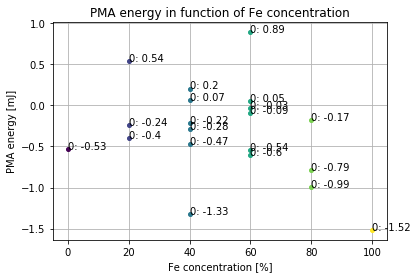

./graphs/charge-relax-v01-_ediff.csv
Index(['DE', 'filename', 'combination', 'ion_position'], dtype='object')


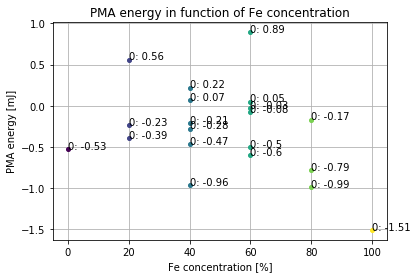

./graphs/charge-relax-v02-_ediff.csv
Index(['DE', 'filename', 'combination', 'ion_position'], dtype='object')


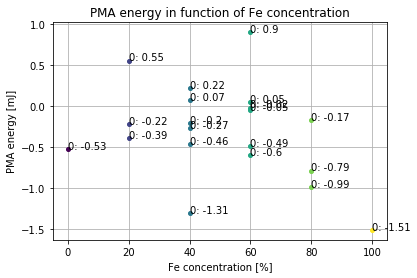

In [46]:
calculate_and_plot_all_folders_sum()